# Balanced Classes
### A variety of class-balancing methods implemented with Random Forests

In [83]:
import sys

# General data processing packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7)
import seaborn as sns 
from torch.utils.data import DataLoader, random_split
import torch

# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Classifier models
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Image feature packages
import mahotas as mt
import cv2

## Data loading

In [2]:
x_train_path = "../ParanormalDistributions/Data/X_train.npy"
y_train_path = "../ParanormalDistributions/Data/y_train.npy"

In [4]:
def get_dataloaders(y_train_path, x_train_path, split_size=0.8):
    # Load as numpy arrays
    y_train = np.load(y_train_path)
    X_train = np.load(x_train_path, mmap_mode='r')
 
    # Create training/test split
    split = int(split_size * len(y_train))
    split_r = len(y_train) - split

    # Put data with labels into a single array.
    print("Preparing data ...")
    X_labelled = list(zip(X_train,y_train))
    print("Packaging data into DataLoaders...")
 
    torch.manual_seed(10)
    train_data, validate_data = random_split(X_labelled, [split, split_r])
    train_dataloader = DataLoader(train_data, shuffle=True)
    validate_dataloader = DataLoader(validate_data, shuffle=True)

    print("Freeing up memory...")
    del X_labelled
    del train_data
    del validate_data
  
    return train_dataloader, validate_dataloader

In [5]:
train_dataloader, validate_dataloader = get_dataloaders(y_train_path,x_train_path)

Preparing data ...
Packaging data into DataLoaders...
Freeing up memory...


## Generate Haralick features

In [6]:
def extract_features(image):
    # calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)

    # take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

In [23]:
def get_haralick(input_dataloader):
    haralick_features = []
    y = []
    for batch_features, batch_label in iter(input_dataloader):
        j = 0 
        while j < len(batch_features):
            gray =  np.dot(batch_features[j][...,:3], [76.245, 149.685, 29.07]) #combines unormalisation and 
            haralick_feature = extract_features(gray.astype(int))
            haralick_features.append(haralick_feature)
            y.append(batch_label[j])
            j = j + 1 
    return haralick_features, y

In [24]:
haralick_train, y_train = get_haralick(train_dataloader)
haralick_validate, y_validate = get_haralick(validate_dataloader)

## Standard Random Forest without balancing, for comparison

0.8273531821920665
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89        92
         1.0       0.78      0.75      0.76        52
         2.0       0.70      0.82      0.75        28
         3.0       0.00      0.00      0.00         0

    accuracy                           0.81       172
   macro avg       0.60      0.60      0.60       172
weighted avg       0.85      0.81      0.83       172



/opt/anaconda3/envs/GroupD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/GroupD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/GroupD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


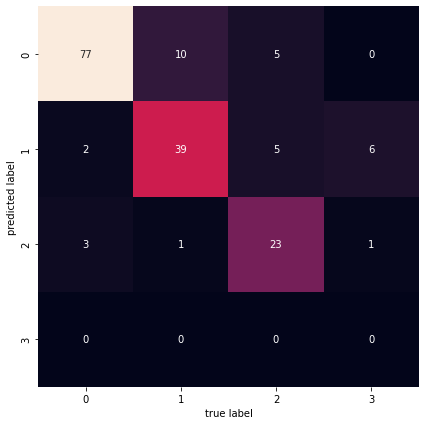

In [110]:
# Standard Random Forest
skBootWeight = RandomForestClassifier(n_estimators=750)
skBootWeight.fit(haralick_train, y_train)
y_pred = skBootWeight.predict(haralick_validate)

print(metrics.f1_score(y_pred,y_validate,average='weighted'))
print(metrics.classification_report(y_pred, y_validate))

# confusion matrix plot
mat = confusion_matrix(y_validate, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Method a) Balanced Random Forest Classifier
Has the best f1 score for class 3, but with a significant cost to overall weighted f1 score.

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86        83
         1.0       0.62      0.82      0.70        38
         2.0       0.70      0.72      0.71        32
         3.0       0.43      0.16      0.23        19

    accuracy                           0.74       172
   macro avg       0.65      0.64      0.63       172
weighted avg       0.73      0.74      0.73       172

0.7281034856616252


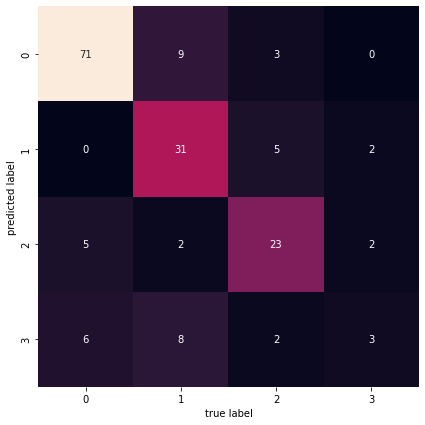

In [107]:
balForest = BalancedRandomForestClassifier(n_estimators=700)
balForest.fit(haralick_train, y_train)

y_pred = balForest.predict(haralick_validate)

print(metrics.classification_report(y_pred, y_validate))
print(metrics.f1_score(y_pred,y_validate,average='weighted'))

# confusion matrix plot
mat = confusion_matrix(y_validate, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Method b) Sklearn's bootstrap class weighting
Balances class distribution for each tree in the forest.
Does not perform well for improving class 3's predictions.

0.8501698486505339
              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90        91
         1.0       0.80      0.77      0.78        52
         2.0       0.76      0.86      0.81        29
         3.0       0.00      0.00      0.00         0

    accuracy                           0.83       172
   macro avg       0.63      0.62      0.62       172
weighted avg       0.87      0.83      0.85       172



/opt/anaconda3/envs/GroupD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/GroupD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/GroupD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


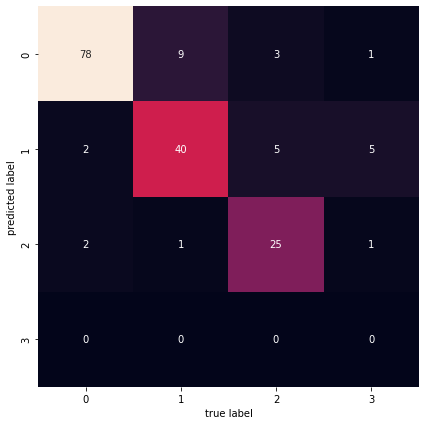

In [86]:
skBootWeight = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample')
skBootWeight.fit(haralick_train, y_train)
y_pred = skBootWeight.predict(haralick_validate)

# confusion matrix plot
mat = confusion_matrix(y_validate, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# metrics
print(metrics.f1_score(y_pred,y_validate,average='weighted'))
print(metrics.classification_report(y_pred, y_validate))



## Method c) SMOTE oversampling followed by undersampling with Balanced Random Forest Classifier
Seems to work the best in terms of improving the class 3 f1 score without decreasing the overall f1 weighted score too much.

0.8284947845417237
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89        88
         1.0       0.78      0.78      0.78        50
         2.0       0.76      0.81      0.78        31
         3.0       0.14      0.33      0.20         3

    accuracy                           0.82       172
   macro avg       0.65      0.70      0.66       172
weighted avg       0.84      0.82      0.83       172



Text(47.040000000000006, 0.5, 'predicted label')

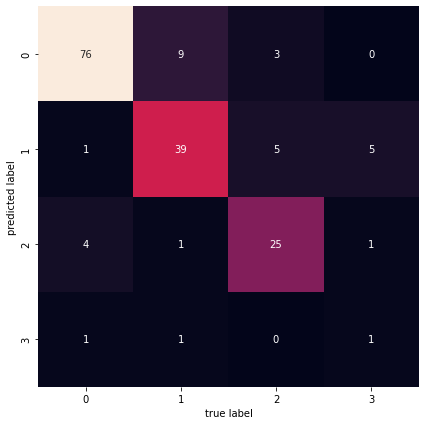

In [106]:
model = BalancedRandomForestClassifier(n_estimators=750, max_features=3)
over = SMOTE()
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
pipeline.fit(haralick_train, y_train)
y_pred = pipeline.predict(haralick_validate)

print(metrics.f1_score(y_pred,y_validate,average='weighted'))
print(metrics.classification_report(y_pred, y_validate))

# confusion matrix plot
mat = confusion_matrix(y_validate, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

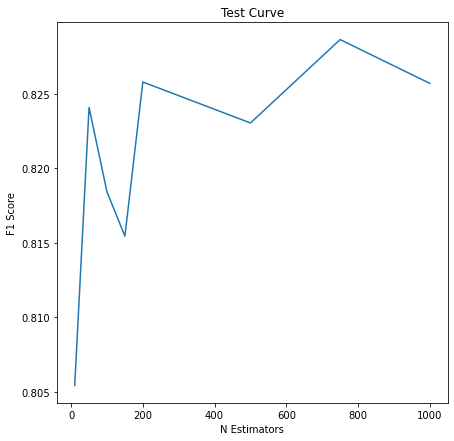

In [97]:
# Hyperparameter tuning: determining the best number of estimators in the forest

estimators = [10,50,100,150,200,500,750,1000]
f1_scores = []
iters = []
n = 0
over = SMOTE()
for estimator in estimators:
    model = BalancedRandomForestClassifier(n_estimators=estimator)
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    scores = 0
    for i in range(0,5):
        pipeline.fit(haralick_train, y_train)
        y_pred = pipeline.predict(haralick_validate)
        scores += metrics.f1_score(y_pred,y_validate,average='weighted')
    
    f1_scores.append(scores/5)
    n = n + 1 
    iters.append(estimator)

# plotting
plt.title("Test Curve")
plt.plot(iters, f1_scores, label="Test")
plt.xlabel("N Estimators")
plt.ylabel("F1 Score")
plt.show()

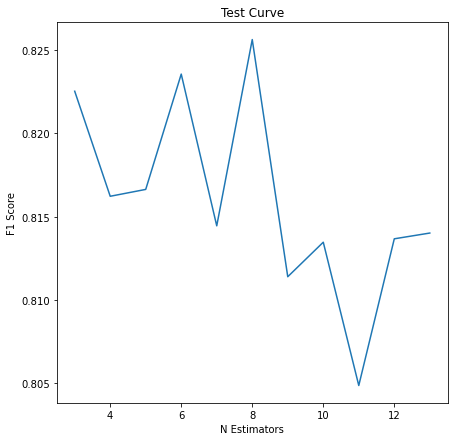

In [101]:
# Hyperparameter tuning: determining the best maximum number of features to select in feature subsampling
max_feats = range(int(np.sqrt(14)),14)
f1_scores = []
iters = []
n = 0
over = SMOTE()
for nfeat in max_feats:
    model = BalancedRandomForestClassifier(n_estimators=750, max_features=nfeat)
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    scores = 0
    for i in range(0,5):
        pipeline.fit(haralick_train, y_train)
        y_pred = pipeline.predict(haralick_validate)
        scores += metrics.f1_score(y_pred,y_validate,average='weighted')
    
    f1_scores.append(scores/5)
    n = n + 1 
    iters.append(nfeat)

# plotting
plt.title("Test Curve")
plt.plot(iters, f1_scores, label="Test")
plt.xlabel("Max features")
plt.ylabel("F1 Score")
plt.show()

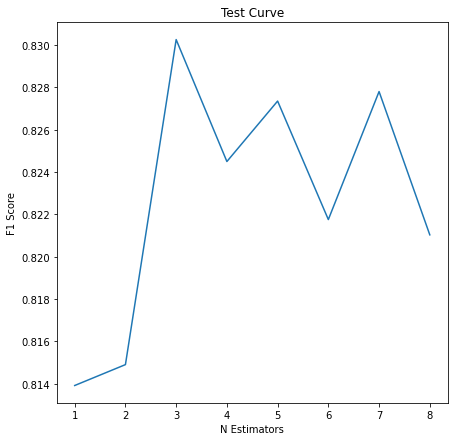

In [102]:
max_feats = range(1,9)
f1_scores = []
iters = []
n = 0
over = SMOTE()
for nfeat in max_feats:
    model = BalancedRandomForestClassifier(n_estimators=750, max_features=nfeat)
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    scores = 0
    for i in range(0,5):
        pipeline.fit(haralick_train, y_train)
        y_pred = pipeline.predict(haralick_validate)
        scores += metrics.f1_score(y_pred,y_validate,average='weighted')
    
    f1_scores.append(scores/5)
    n = n + 1 
    iters.append(nfeat)

# plotting
plt.title("Test Curve")
plt.plot(iters, f1_scores, label="Test")
plt.xlabel("Max features")
plt.ylabel("F1 Score")
plt.show()